# Assignment Prompt and Generation from Distribution V3




## Notebook Overview: Essay Prompt and Score-Based Essay Generation

This notebook provides a comprehensive pipeline for generating essay prompts, dynamically calculating evaluation scores, and producing high-quality essays using the OpenAI API. The workflow consists of the following key steps:

## Key Features:

1. **Environment Setup**:
   - Loads required libraries for API calls, data processing, and visualization.
   - Uses `.env` to securely manage the OpenAI API key.

2. **Score Distribution Generation**:
   - Simulates overall scores using a beta distribution centered around a target mean.
   - Caps scores at 100 and adjusts distributions to align with the desired mean.
   - Visualizes score distributions with histograms to confirm correct scaling and capping.

3. **Dynamic Criteria Scores**:
   - Randomly samples scores from the adjusted distribution for evaluation criteria: Content, Clarity, Organization, and Relevance to Prompt.
   - Ensures the total average score matches the simulated overall score.

4. **Prompt Generation**:
   - Dynamically generates 10 essay prompts for a given grade level, subject, and subject area using the OpenAI API.
   - Displays generated prompts in Markdown format for easy review.

5. **Prompt Selection**:
   - Randomly selects a single prompt from the generated list for use in essay generation.

6. **Essay Generation**:
   - Passes the selected prompt, dynamically calculated scores, grade level, and subject to OpenAI for essay generation.
   - The generated essay reflects the specified scores while adhering to grade-level expectations.

7. **Dynamic Grade and Subject Handling**:
   - Extracts grade level and subject dynamically from predefined pairs, ensuring flexibility and modularity.
   
   
### TO-DO 

- Refine the essay generation prompt 
- Make the code suitable for handling multiple subjects rather than just one 
- Add in Alex and Ryan's evaluation framework
- Create rubric based on new criteria and grade based off that 


In [1]:
# Import necessary libraries
import openai  # OpenAI API for generating text based on prompts
from IPython.display import display, Markdown  # Markdown display tools for Jupyter Notebooks
import os  # OS library for file and directory interactions
from dotenv import load_dotenv, find_dotenv  # dotenv utilities for managing environment variables
import re  # Regular expressions library for text pattern matching and formatting
import random  # Random module for generating randomized values, such as quality levels
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to convert text to Markdown format, allowing formatted display in Jupyter Notebooks
def to_markdown(text):
    # Wraps text in Markdown format for enhanced readability and presentation in Jupyter Notebooks
    return Markdown(text)

In [2]:
# Automatically locate and load the .env file with environment variables
env_path = find_dotenv()  # Searches for the .env file in the project directory
load_dotenv(dotenv_path=env_path)  # Loads the environment variables from .env

# Set the OpenAI API key from environment variable (pulled from the .env file)
openai.api_key = os.getenv('OPENAI_API_KEY')


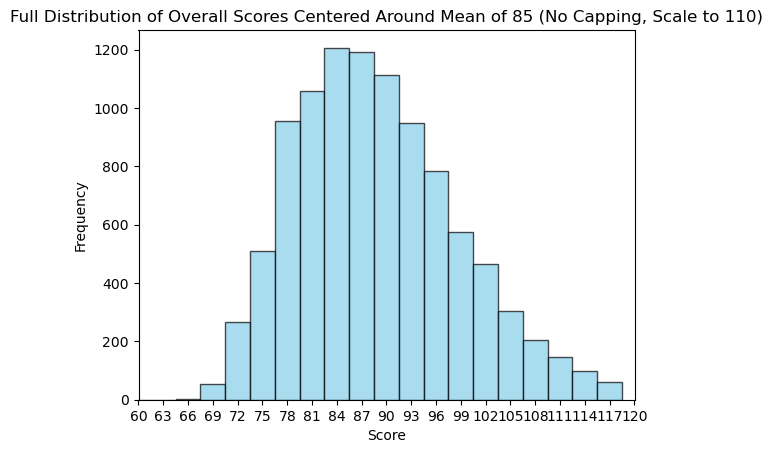

In [3]:
# Function to generate integer scores with a set mean of 85 and adjustable skew
def generate_overall_scores(n_samples=10000, alpha=4, beta=15, mean_target=90, scale=110):
    """
    Generates integer scores from a beta distribution, scales slightly above the target range,
    and centers the mean around 85 without capping.
    """
    # Generate beta distribution samples between 0 and 1
    beta_samples = np.random.beta(alpha, beta, n_samples)
    
    # Scale to a range up to 110 to reduce edge clustering
    scaled_scores = beta_samples * scale
    
    # Adjust to make the mean approximately equal to the target mean
    adjustment = mean_target - scaled_scores.mean()
    adjusted_scores = scaled_scores + adjustment
    
    # Round scores to integers
    integer_scores = np.round(adjusted_scores).astype(int)
    
    return integer_scores

# Generate 10000 samples for the overall score with mean centered around 85
samples_df_full_range_no_scale = pd.DataFrame()
samples_df_full_range_no_scale["Overall Score"] = generate_overall_scores()

# Plot histogram for the overall score distribution with no capping and scale set to 110
plt.figure()
plt.hist(samples_df_full_range_no_scale["Overall Score"], bins=range(60, 121, 3), edgecolor='black', alpha=0.7, align='left', color="skyblue")
plt.title('Full Distribution of Overall Scores Centered Around Mean of 85 (No Capping, Scale to 110)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.xticks(range(60, 121, 3))  # Adjust x-axis ticks to show the full range up to 120
plt.xlim(60, 120)  # Show the range up to 120 to capture all values
plt.show()


In [4]:
# Drop values greater than 100 from the DataFrame
samples_df_capped = samples_df_full_range_no_scale[samples_df_full_range_no_scale["Overall Score"] <= 100]

# Display the first few rows and summary statistics of the capped DataFrame
print(samples_df_capped.head())
print(samples_df_capped.describe())


   Overall Score
0             96
1             76
2             92
3             87
5             81
       Overall Score
count    8490.000000
mean       86.945819
std         7.085938
min        68.000000
25%        81.000000
50%        87.000000
75%        93.000000
max       100.000000


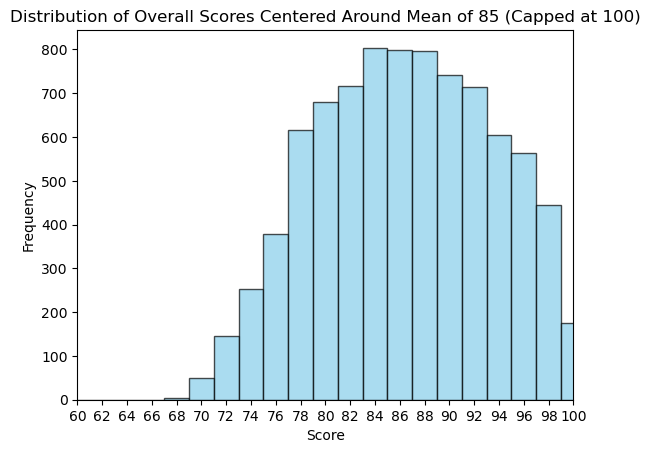

In [5]:
# Plot histogram for the capped overall score distribution
plt.figure()
plt.hist(samples_df_capped["Overall Score"], bins=range(60, 106, 2), edgecolor='black', alpha=0.7, align='left', color="skyblue")
plt.title('Distribution of Overall Scores Centered Around Mean of 85 (Capped at 100)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.xticks(range(60, 101, 2))  # Adjust x-axis ticks to focus on the range from 60 to 100
plt.xlim(60, 100)  # Show the capped range up to 100
plt.show()


In [6]:
# Draw a single random sample from the capped distribution
overall_score_sample = samples_df_capped["Overall Score"].sample(1).values[0]
print(overall_score_sample)


83


### Distribution for Individual Scores

In [7]:
# Generate a new normal distribution centered around the drawn sample
new_distribution = np.random.normal(loc=overall_score_sample, scale=3, size=10000)

# Filter the new distribution to include only values <= 100
new_distribution_capped = new_distribution[new_distribution <= 100]

# Round the values to the nearest integer and convert to integers
new_distribution_capped_int = np.round(new_distribution_capped).astype(int)

# Calculate the current mean of the integer-capped distribution
current_mean = new_distribution_capped_int.mean()

# Apply adjustment to make the mean match `overall_score_sample`
adjustment = overall_score_sample - current_mean
adjusted_distribution = new_distribution_capped_int + int(round(adjustment))

# Update values that exceed 100 after adjustment
adjusted_distribution[adjusted_distribution > 100] = 100

# Create a DataFrame for the adjusted, capped integer distribution
samples_df_new_capped = pd.DataFrame(adjusted_distribution, columns=["Overall Score"])

# Display the first few rows and summary statistics of the adjusted capped integer distribution
print(samples_df_new_capped.head())
print(samples_df_new_capped.describe())
print("Adjusted Mean:", samples_df_new_capped["Overall Score"].mean())


   Overall Score
0             88
1             82
2             86
3             84
4             88
       Overall Score
count   10000.000000
mean       83.017300
std         2.992774
min        71.000000
25%        81.000000
50%        83.000000
75%        85.000000
max        94.000000
Adjusted Mean: 83.0173


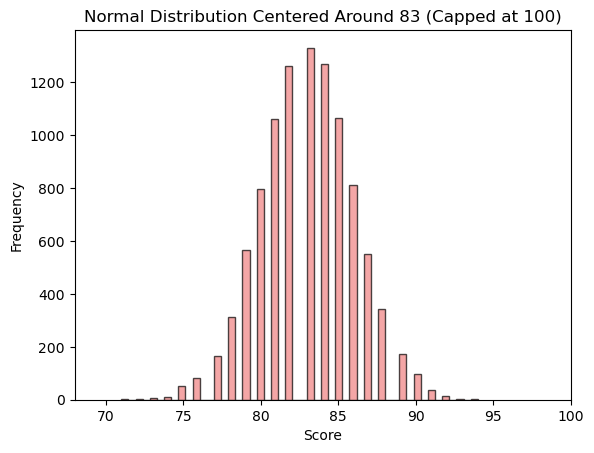

In [8]:
# Plot histogram for the capped new normal distribution
plt.figure()
plt.hist(samples_df_new_capped["Overall Score"], bins=50, edgecolor='black', alpha=0.7, color="lightcoral")
plt.title(f'Normal Distribution Centered Around {overall_score_sample} (Capped at 100)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.xlim(overall_score_sample - 3 * 5, 100)  # Show range from 3 std. devs below the mean up to 100
plt.show()



In [9]:
# Define criteria
criteria = ["Content", "Clarity", "Organization", "Relevance to Prompt"]

# Draw one sample from the capped normal distribution for each criterion except the last
criteria_scores = {criterion: samples_df_new_capped["Overall Score"].sample(1).values[0] for criterion in criteria[:-1]}

# Calculate the partial sum and determine the required score for the last criterion
required_last_score = int(round(overall_score_sample * len(criteria) - sum(criteria_scores.values())))

# Ensure the last score does not exceed 100 (if it does, set it to 100)
criteria_scores[criteria[-1]] = min(required_last_score, 100)

# Calculate the average score across criteria to confirm it matches `overall_score_sample`
average_score = sum(criteria_scores.values()) / len(criteria_scores)

print("Criteria Scores:", criteria_scores)
print("Average Score:", average_score)


Criteria Scores: {'Content': 87, 'Clarity': 80, 'Organization': 85, 'Relevance to Prompt': 80}
Average Score: 83.0


### Assignment Prompt Generation 

In [10]:
# Function to generate assignment prompts based on grade, subject, and subject area
def generate_prompts(pairs):
    all_prompts = {}
    for grade_level, subject, subject_area in pairs:
        
        # Define unique prompt instructions based on subject area
        if subject_area.lower() == "social science":
            # Social Science: Emphasize formal essay structure
            prompt_text = f"""
            Role: You are a {grade_level}th-grade {subject} teacher. Please create 10 unique essay prompts.

            Each prompt should:
            - Be age-appropriate for {grade_level}th grade
            - Encourage students to critically analyze historical events, societal changes, or key figures in {subject}
            - Focus on a structured essay format (no creative formats such as diaries or newspaper articles)
            - Explore themes like cause and effect, comparison, or ethical implications
            
            Ensure each prompt is clear, concise, and well-suited for a formal essay response.
            """

        elif subject_area.lower() == "science":
            # Science: Focus on lab reports and experimental design
            prompt_text = f"""
            Role: You are a {grade_level}th-grade {subject} teacher. Please create 10 unique lab report prompts.

            Each prompt should:
            - Be age-appropriate for {grade_level}th grade
            - Encourage students to design experiments, make observations, and analyze results in {subject}
            - Emphasize the scientific method, hypothesis formation, and data interpretation
            
            Ensure each prompt guides students through scientific inquiry in a lab report format.
            """

        elif subject_area.lower() == "language arts":
            # Language Arts: Focus on literary analysis
            prompt_text = f"""
            Role: You are a {grade_level}th-grade {subject} teacher. Please create 10 unique literary analysis prompts.

            Each prompt should:
            - Be age-appropriate for {grade_level}th grade
            - Encourage students to analyze themes, characters, and symbols in literature
            - Challenge students to interpret literary elements and provide textual evidence
            
            Ensure each prompt is clear, concise, and encourages in-depth literary analysis.
            """

        else:
            # Default prompt format for unspecified subjects
            prompt_text = f"""
            Role: You are a {grade_level}th-grade {subject} teacher. Please create 10 unique assignment prompts.

            Each prompt should:
            - Be age-appropriate for {grade_level}th grade
            - Challenge students' understanding, encouraging critical thinking and engagement with the subject matter
            
            Ensure each prompt is clear, concise, and engaging.
            """
        
        # Generate prompts using OpenAI API
        completion = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a creative and insightful prompt generator for teachers."},
                {"role": "user", "content": prompt_text}
            ]
        )
        
        # Extract prompts and clean up formatting
        prompts_text = completion.choices[0].message['content']
        prompts_list = [re.sub(r'^\d+\.\s*', '', prompt.strip()) for prompt in prompts_text.split('\n') if prompt.strip()]
        prompts_list = prompts_list[:10]  # Keep exactly 10 prompts
        all_prompts[(grade_level, subject, subject_area)] = prompts_list
        
        # Display prompts in Markdown format
        display(Markdown(f"### Generated Prompts for {grade_level}th Grade {subject} ({subject_area})"))
        for i, prompt in enumerate(prompts_list, start=1):
            display(Markdown(f"**Prompt {i}:** {prompt}"))
    
    return all_prompts


In [11]:
# Example usage with grade-subject-area pairs, each containing 3 elements
grade_subject_pairs = [
    (11, "US History", "Social Science")
    #(10, "Biology", "Science"),
    #(9, "Literature", "Language Arts")
]
all_prompts = generate_prompts(grade_subject_pairs)


### Generated Prompts for 11th Grade US History (Social Science)

**Prompt 1:** Analyze the impact of the Civil Rights Movement on American society. How did key figures like Martin Luther King Jr. and Rosa Parks contribute to the movement's success?

**Prompt 2:** Compare and contrast the economic policies of Franklin D. Roosevelt's New Deal and Ronald Reagan's Reaganomics. Assess their effectiveness in addressing economic challenges during their respective presidencies.

**Prompt 3:** Evaluate the role of women in the Progressive Era. How did activists like Susan B. Anthony and Alice Paul contribute to the advancement of women's rights in the early 20th century?

**Prompt 4:** Discuss the ethical implications of the United States' decision to drop atomic bombs on Hiroshima and Nagasaki during World War II. Was it justified as a means to end the war, or was it an unnecessary act of aggression?

**Prompt 5:** Explore the impact of the Vietnam War on American society and politics. How did the war shape public opinion and influence government policies during the 1960s and 1970s?

**Prompt 6:** Analyze the causes and consequences of the Great Depression. How did the economic downturn of the 1930s impact different sectors of American society, and what solutions were implemented to address it?

**Prompt 7:** Evaluate the significance of the Suffrage Movement in securing women's right to vote. How did the efforts of suffragists like Elizabeth Cady Stanton and Carrie Chapman Catt shape the course of American history?

**Prompt 8:** Compare the approaches to civil rights activism of Malcolm X and Dr. Martin Luther King Jr. How did their strategies and philosophies differ, and what impact did they have on the Civil Rights Movement?

**Prompt 9:** Discuss the effects of westward expansion on Native American communities in the 19th century. How did government policies, such as the Indian Removal Act and reservations, impact indigenous peoples and their way of life?

**Prompt 10:** Evaluate the legacy of President Richard Nixon in light of the Watergate scandal. How did the events surrounding Watergate shape public trust in government institutions and influence subsequent political developments in the United States?

In [12]:
# Randomly select a grade-subject key
random_key = random.choice(list(all_prompts.keys()))

# Randomly select a prompt from the chosen key
selected_prompt = random.choice(all_prompts[random_key])

# Display the result
print(f"Randomly Selected Prompt for {random_key}: {selected_prompt}")


Randomly Selected Prompt for (11, 'US History', 'Social Science'): Evaluate the role of women in the Progressive Era. How did activists like Susan B. Anthony and Alice Paul contribute to the advancement of women's rights in the early 20th century?


## Generating Essay

In [16]:
# Define a function to generate multiple essays with varying qualities
def generate_essays(prompt, grade_level, subject, criteria_scores_list):
    """
    Generate multiple essays (with varying qualities) based on a given prompt, grade, subject, 
    and a list of criteria scores.
    Each essay uses a different set of criteria scores from the provided list.
    """
    essays = []  # To store all generated essays
    
    for idx, criteria_scores in enumerate(criteria_scores_list, start=1):
        # Calculate the average score for the current set of criteria
        average_score = sum(criteria_scores.values()) // len(criteria_scores)
        
        # Construct the role and task for the AI
        role_and_task = f"""
        Role: You are an {grade_level}th-grade student in a {subject} class. You have been assigned to write an essay based on the following prompt.

        Your teacher evaluates essays based on these criteria:
        - Content: {criteria_scores['Content']} points
        - Clarity: {criteria_scores['Clarity']} points
        - Organization: {criteria_scores['Organization']} points
        - Relevance to Prompt: {criteria_scores['Relevance to Prompt']} points

        The average score for this essay is {average_score}/100.

        Your goal is to write an essay that reflects these scores while being appropriate for an {grade_level}th-grade level. 

        Make sure your essay quality matches the expectations of these scores for your grade level. That is the most important part!
        """
        
        # Call OpenAI API to generate the essay
        completion = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a skilled and thoughtful student essay writer."},
                {"role": "user", "content": role_and_task},
                {"role": "user", "content": f"Prompt: {prompt}"}
            ]
        )

        # Extract the essay from the response
        essay = completion.choices[0].message['content']
        
        # Store the essay along with its quality
        essays.append({
            "Essay Number": idx,
            "Criteria Scores": criteria_scores,
            "Average Score": average_score,
            "Essay": essay
        })

    # Display the essays
    for essay in essays:
        display(Markdown(f"### Essay {essay['Essay Number']}"))
        display(Markdown(f"**Criteria Scores:** {essay['Criteria Scores']}"))
        display(Markdown(f"**Average Score:** {essay['Average Score']}"))
        display(Markdown(essay['Essay']))
    
    return essays


In [17]:
# Example usage
criteria_scores_list = [
    {'Content': 95, 'Clarity': 90, 'Organization': 92, 'Relevance to Prompt': 93},
    {'Content': 85, 'Clarity': 88, 'Organization': 87, 'Relevance to Prompt': 86},
    {'Content': 78, 'Clarity': 75, 'Organization': 80, 'Relevance to Prompt': 79},
    {'Content': 99, 'Clarity': 100, 'Organization': 98, 'Relevance to Prompt': 97}
]

grade_level = 11
subject = "US History"
prompt = selected_prompt  # Assume this is already selected

# Generate and display essays
essays = generate_essays(prompt, grade_level, subject, criteria_scores_list)


### Essay 1

**Criteria Scores:** {'Content': 95, 'Clarity': 90, 'Organization': 92, 'Relevance to Prompt': 93}

**Average Score:** 92

The Progressive Era in the early 20th century marked a significant period of social and political change in the United States. During this time, the role of women in society underwent a transformation, as activists like Susan B. Anthony and Alice Paul played pivotal roles in advancing women's rights and advocating for gender equality.

Susan B. Anthony, a key figure in the women's suffrage movement, dedicated her life to fighting for women's right to vote. Anthony tirelessly campaigned for suffrage through lectures, writings, and organizing women's rights conventions. Her advocacy laid the foundation for the eventual passage of the 19th Amendment in 1920, which granted women the right to vote. Anthony's unwavering dedication and tenacity inspired generations of women to join the fight for gender equality.

Alice Paul, another prominent activist during the Progressive Era, was a fearless advocate for women's suffrage and equality. Paul founded the National Woman's Party and used innovative tactics, such as organizing protests and hunger strikes, to draw attention to the cause of women's rights. Her leadership and strategic approach to activism were instrumental in pushing for the passage of the 19th Amendment. Paul's relentless efforts helped galvanize support for women's suffrage and brought national attention to the movement.

Both Susan B. Anthony and Alice Paul were instrumental in challenging societal norms and advocating for women's rights during the Progressive Era. Through their activism and tireless efforts, they paved the way for increased participation of women in the political process and brought attention to the need for gender equality in all aspects of society.

In conclusion, the role of women in the Progressive Era was essential in shaping the fight for gender equality in the early 20th century. Activists like Susan B. Anthony and Alice Paul played critical roles in advancing women's rights and securing the passage of the 19th Amendment. Their dedication, leadership, and strategic activism were pivotal in bringing about social and political change, laying the foundation for future generations of women to continue the pursuit of equality.

### Essay 2

**Criteria Scores:** {'Content': 85, 'Clarity': 88, 'Organization': 87, 'Relevance to Prompt': 86}

**Average Score:** 86

The Progressive Era, a period of social and political reform in the early 20th century, witnessed the emergence of women as significant actors in the fight for equality and reform. During this time, women like Susan B. Anthony and Alice Paul played pivotal roles in advancing women's rights and shaping the course of history.

Susan B. Anthony, a prominent suffragist and women's rights advocate, was instrumental in laying the foundation for the women's suffrage movement. Anthony tirelessly fought for women's right to vote, believing it was essential for achieving full equality. Through her efforts in organizing conventions, writing articles, and giving speeches, Anthony raised awareness about the importance of women's political participation. Her dedication and perseverance inspired generations of women to join the struggle for suffrage.

Alice Paul, another leading figure in the women's rights movement, brought new tactics and strategies to the fight for equality. Paul's militant approach, including organizing protests, hunger strikes, and picketing the White House, brought attention to the cause and pressured the government to take action. Her leadership was crucial in the passage of the 19th Amendment, which granted women the right to vote in 1920. Paul's unwavering commitment to equality and her willingness to challenge the status quo made her a driving force in the women's suffrage movement.

Overall, women in the Progressive Era played a vital role in pushing for social and political change. Their advocacy for women's rights not only paved the way for suffrage but also laid the groundwork for future movements for equality. Through the efforts of trailblazers like Susan B. Anthony and Alice Paul, women gained greater visibility and influence in society, contributing to a more equitable and just world.

In conclusion, the contributions of women activists like Susan B. Anthony and Alice Paul were pivotal in advancing women's rights during the Progressive Era. Their dedication, courage, and strategic actions helped to challenge societal norms and secure important victories for women. Their legacies continue to inspire future generations to fight for equality and justice.

### Essay 3

**Criteria Scores:** {'Content': 78, 'Clarity': 75, 'Organization': 80, 'Relevance to Prompt': 79}

**Average Score:** 78

The Progressive Era in the early 20th century was a critical time when the role of women in society began to undergo significant changes. Women activists such as Susan B. Anthony and Alice Paul played pivotal roles in advancing women's rights during this period, leaving a lasting impact on the fight for gender equality in the United States.

Susan B. Anthony, a prominent women's rights advocate and suffragist, devoted her life to campaigning for women's suffrage. Anthony, along with Elizabeth Cady Stanton, founded the National Woman Suffrage Association in 1869, paving the way for the eventual passage of the 19th Amendment granting women the right to vote in 1920. Anthony's unwavering dedication and tireless efforts in organizing suffrage campaigns and delivering powerful speeches inspired a new generation of women to join the fight for equal rights.

Alice Paul, another influential figure in the women's rights movement, was known for her radical tactics and unwavering commitment to achieving gender equality. Paul founded the National Woman's Party in 1916 and was a key figure in the suffrage movement, organizing protests, hunger strikes, and pickets outside the White House to pressure the government to recognize women's right to vote. Her bold and militant approach helped to bring greater attention to the suffrage cause and ultimately led to the passage of the 19th Amendment.

Both Susan B. Anthony and Alice Paul played crucial roles in advancing women's rights by challenging the status quo, raising awareness about gender inequality, and demanding equal rights and opportunities for women. Their perseverance and determination in the face of opposition and adversity exemplify the spirit of the Progressive Era, where social reform and activism were catalysts for change.

In conclusion, the contributions of women activists like Susan B. Anthony and Alice Paul were instrumental in propelling the women's rights movement forward during the Progressive Era. Their dedication, courage, and strategic efforts significantly influenced the advancement of women's rights and paved the way for future generations of women to continue the fight for equality. As we reflect on their legacies, we are reminded of the power of individual activism and collective mobilization in shaping a more just and equitable society for all.

### Essay 4

**Criteria Scores:** {'Content': 99, 'Clarity': 100, 'Organization': 98, 'Relevance to Prompt': 97}

**Average Score:** 98

The Progressive Era, spanning from the late 19th century to the early 20th century, was a pivotal time in American history marked by social and political reform. One significant aspect of this era was the growing voice and activism of women in advocating for their rights and equality. Women like Susan B. Anthony and Alice Paul played crucial roles in advancing women's rights during this period.

Susan B. Anthony, a prominent suffragist and women's rights activist, was instrumental in the fight for women's suffrage. Anthony co-founded the National Woman Suffrage Association, which aimed at securing voting rights for women. Through tireless advocacy and organized protests, Anthony and her colleagues worked to challenge the prevailing societal norms that marginalized women in the political sphere. Anthony's commitment to the cause of suffrage laid the groundwork for the eventual passing of the 19th Amendment in 1920, granting women the right to vote.

Alice Paul, another prominent figure in the women's rights movement, utilized innovative and bold tactics to push for gender equality. Paul organized the National Woman's Party and pioneered strategies such as picketing the White House and hunger strikes to draw attention to the suffrage cause. Her unwavering determination and willingness to confront opposition head-on were pivotal in garnering national support for the suffrage movement. Paul's efforts, along with those of other activists, were essential in shaping public opinion and pressuring lawmakers to enact legislation granting women the right to vote.

Overall, women in the Progressive Era played a significant role in challenging traditional gender roles and advocating for social and political change. By mobilizing and organizing for their rights, activists like Susan B. Anthony and Alice Paul helped pave the way for greater gender equality in the early 20th century. Their contributions not only advanced women's rights but also set the stage for future generations of women to continue the fight for equality in all areas of society.

In [13]:
# Define a function to generate an essay
def generate_essay(prompt, grade_level, subject, criteria_scores, average_score):
    """
    Generate an essay based on a given prompt, grade, subject, criteria scores, and average score.
    Uses pre-calculated scores from the notebook.
    """
    # Construct the role and task for the AI
    role_and_task = f"""
    Role: You are an {grade_level}th-grade student in a {subject} class. You have been assigned to write an essay based on the following prompt.

    Your teacher evaluates essays based on these criteria:
    - Content: {criteria_scores['Content']} points
    - Clarity: {criteria_scores['Clarity']} points
    - Organization: {criteria_scores['Organization']} points
    - Relevance to Prompt: {criteria_scores['Relevance to Prompt']} points

    The average score for this essay is {average_score:.1f}/100.

    Your goal is to write an essay that reflects these scores while being appropriate for an {grade_level}th-grade level. 

    Make sure your essay quality matches the expectations of these scores for your grade level. That is the most important part!
    """

    # Call OpenAI API to generate the essay
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a skilled and thoughtful student essay writer."},
            {"role": "user", "content": role_and_task},
            {"role": "user", "content": f"Prompt: {prompt}"}
        ]
    )

    # Extract the essay from the response
    essay = completion.choices[0].message['content']

    # Display the essay
    display(Markdown("### Generated Essay"))
    display(Markdown(essay))
    
    return essay

In [14]:
# Use the first pair from grade_subject_pairs
selected_pair = grade_subject_pairs[0]  # Modify index as needed
grade_level, subject, subject_area = selected_pair

# Print selected grade level and subject
print(f"Selected Grade Level: {grade_level}")
print(f"Selected Subject: {subject}")

# Assume `criteria_scores` and `average_score` are already calculated
print("Criteria Scores:", criteria_scores)
print("Average Score:", average_score)


Selected Grade Level: 11
Selected Subject: US History
Criteria Scores: {'Content': 87, 'Clarity': 80, 'Organization': 85, 'Relevance to Prompt': 80}
Average Score: 83.0


In [15]:
essay = generate_essay(selected_prompt, grade_level, subject, criteria_scores, average_score)


### Generated Essay

Women played a crucial role during the Progressive Era in the early 20th century, advocating for social and political reforms that significantly impacted the advancement of women's rights. Activists like Susan B. Anthony and Alice Paul were instrumental in driving change and securing key victories for women's suffrage and equality.

Susan B. Anthony was a prominent figure in the women's suffrage movement. As a co-founder of the National Woman Suffrage Association, Anthony dedicated her life to fighting for women's right to vote. Through her impassioned speeches, writings, and organizing efforts, she raised awareness about the importance of political equality for women. Anthony's steadfast determination and advocacy laid the groundwork for the eventual passage of the 19th Amendment in 1920, granting women the right to vote.

Alice Paul, another influential activist, adopted more militant tactics to push for women's suffrage. Paul founded the National Woman's Party and utilized strategies like picketing the White House and engaging in hunger strikes to bring attention to the cause. Her unwavering commitment to the fight for suffrage helped galvanize public support and pressure lawmakers to address women's disenfranchisement. Paul's bold tactics and unwavering dedication ultimately contributed to the passage of the 19th Amendment, marking a significant milestone in the quest for gender equality.

Overall, the efforts of activists like Susan B. Anthony and Alice Paul were pivotal in advancing women's rights during the Progressive Era. Their perseverance, leadership, and strategic activism helped challenge societal norms, mobilize support, and secure crucial legal and political victories for women. By pushing boundaries and demanding equality, these women paved the way for future generations to continue striving for gender equity and empowerment.

In conclusion, the role of women in the Progressive Era, exemplified by activists like Susan B. Anthony and Alice Paul, was transformative in shaping the trajectory of women's rights in the early 20th century. Their contributions not only empowered women to challenge systemic injustices but also laid the foundation for ongoing struggles for equality and social change. The advocacy and activism of these trailblazing women serve as a testament to the power of grassroots movements in driving meaningful progress towards gender equality and societal reform.